# Residual disease (and debulking) a.k.a surgical outcomes, relationship to cell proportions in Schildkraut HGSOC

Because residual tumour after surgery could signal a more fibrotic milieu, we tested whether any macroscopic residual disease altered cell fractions by contrasting “no residual” versus “any residual” tumours with Welch t-tests and Bonferroni adjustment. Stromal content was modestly higher in tumours that left any macroscopic disease behind at surgery (mean 0.107 vs. 0.081; raw p = 0.019) but the difference fell just short of Bonferroni significance (p-adj = 0.058). Adipocyte (mean 0.135 vs 0.128; p-adj = 0.79) and immune fractions (0.107 vs 0.098; p-adj = 0.34) showed no detectable change. Thus, while stromal cells may accumulate in tumours with sub-optimal cytoreduction surgery (i.e., significant residual disease size), none of the four macro compartments exhibited a statistically robust shift with residual-disease status in this cohort. 

In [3]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import sys

sys.path.insert(1, "../../")
sys.path.insert(1, "../")
sys.path.insert(1, "../../../")

import src.hp as hp

np.random.seed(88)

In [4]:
fractions = ["Adipocytes", "Immune", "Stromal", "Epithelial"]

immune_cells = [
    "B cells",
    "Mast cells",
    "T cells",
    "Monocytes",
    "Plasma cells",
    "NK cells",
    "DC",
    "pDC",
    "Macrophages",
    "ILC",
]

stromal_cells = ["Fibroblasts", "Endothelial cells"]

cont_cols = ["Age", "BMI"]

## Paths

In [5]:
base_path = os.path.dirname(os.getcwd())
meta_path = os.path.join(base_path, "input_data/metadata.xlsx")

## Load InstaPrism cell-fraction tables (processed) and metadata

Proportions

In [6]:
props = pd.read_csv(
    os.path.join(base_path, "input_data/proportions_sch.csv"), index_col=0
)
props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,0.159171,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,0.113022,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.082561,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,0.157235,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,0.141568,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,0.135240,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,0.174205,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,0.114204,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,0.136146,SchildkrautW,20160X98,47937


### Build the analysis table  (clinical + cell fractions)


In [7]:
renaming = hp.get_variable_renaming()
tissue_dictionary = hp.get_tissue_dictionary()

Metadata

In [8]:
# continuous covariates to keep “as is”
meta_full = hp.open_and_clean_meta(
    meta_path=meta_path, renaming=renaming, tissue_dictionary=tissue_dictionary
)

In [9]:
# match index in both
meta_full.index = meta_full.ID
props.index = props.ID
props.drop(columns=["ID", "SampleID", "suid"], inplace=True)

## and merge:
df = meta_full.join(props, how="inner")

cell_types = [
    col for col in df.columns if col not in meta_full.columns and col not in cont_cols
]
cell_types.remove("Dataset")

df

,ID,Age,Event,Time_Yrs,Tissue,Stage,Race,BMI,AdjTx,Residual,...,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset
ID,,,,,,,,,,,,,,,,,,,,,
40143,40143,63,1,8.739220,NaN,3,1,23.218229,1.0,4.0,...,9.808751e-12,0.610632,1.004328e-110,2.784970e-66,3.408820e-86,2.396804e-02,1.848657e-50,0.0,0.113422,SchildkrautW
41377,41377,54,1,1.180014,NaN,3,1,17.428942,NaN,3.0,...,1.760940e-62,0.702189,1.298550e-208,3.770200e-114,5.097006e-86,1.148229e-151,2.716906e-120,0.0,0.169611,SchildkrautW
41387,41387,55,1,11.983573,NaN,3,2,45.470350,1.0,2.0,...,1.680504e-02,0.725604,1.103526e-97,9.654211e-04,3.169795e-58,6.457394e-02,9.868737e-88,0.0,0.064832,SchildkrautB
41391,41391,60,1,4.993840,NaN,3,1,31.340800,NaN,3.0,...,2.241865e-19,0.660983,3.521124e-102,3.787996e-28,1.975079e-50,1.760802e-02,3.608451e-57,0.0,0.119373,SchildkrautW
41435,41435,59,1,4.057495,NaN,3,1,23.922658,NaN,NaN,...,4.262662e-11,0.739953,8.402589e-122,2.637763e-60,2.022724e-88,5.507985e-03,3.092821e-03,0.0,0.110333,SchildkrautW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310266,310266,40,0,9.702186,Fallopian Tube,3,2,28.349557,NaN,NaN,...,1.374198e-10,0.777904,3.501752e-85,4.856912e-52,2.991107e-53,1.842305e-02,3.506149e-04,0.0,0.097551,SchildkrautB
320012,320012,66,0,11.767760,NaN,3,2,37.677475,1.0,4.0,...,1.048037e-48,0.771372,3.272227e-203,2.444034e-102,2.676690e-115,2.749868e-124,8.635726e-145,0.0,0.135411,SchildkrautB
320025,320025,60,1,6.827869,Other,3,2,38.740537,1.0,3.0,...,6.829921e-59,0.660166,6.138234e-174,1.089373e-96,7.514971e-104,2.901155e-89,6.676818e-64,0.0,0.181209,SchildkrautB


In [10]:
## Which cell types to use
df["Immune"] = df[immune_cells].sum(axis=1)
df["Stromal"] = df[stromal_cells].sum(axis=1)
df["Epithelial"] = df["Epithelial cells"]

df_complete = df.copy()

df.dropna(subset="Residual", inplace=True)

df["Residual"].value_counts(dropna=False)

Residual
1.0    110
2.0     99
4.0     52
3.0     39
Name: count, dtype: int64

In [11]:
# ------------------------------------------------------------------
# 1.  Collapse residual-disease codes → two groups
#     1 = “No visible disease (0 mm)”
#     2 = “< 1 cm”, 3 = “≥ 1 cm”, 4 = “Unknown size”
# ------------------------------------------------------------------
res_map = {
    1.0: 0,  # 0 = No residual tumour
    2.0: 1,
    3.0: 1,
    4.0: 1,
}  # 1 = Any residual tumour

df = df.copy()  # keep original intact
df["AnyResidual"] = df["Residual"].map(res_map)

print(
    df.AnyResidual.value_counts(dropna=False).rename(
        {0: "No residual", 1: "Any residual"}
    )
)

AnyResidual
Any residual    190
No residual     110
Name: count, dtype: int64


In [12]:
# ------------------------------------------------------------------
# Welch two-sample t-tests on raw fractions
# ------------------------------------------------------------------
rows = []

for frac in fractions:
    no = df.loc[df.AnyResidual == 0, frac]
    res = df.loc[df.AnyResidual == 1, frac]

    t_stat, p_raw = ttest_ind(res, no, equal_var=False, nan_policy="omit")
    rows.append(
        {
            "Fraction": frac,
            "Mean_NoRes": no.mean(),
            "Mean_Res": res.mean(),
            "Difference": res.mean() - no.mean(),
            "p_raw": p_raw,
        }
    )

out = pd.DataFrame(rows)
out["p_bonf"] = multipletests(out.p_raw, method="bonferroni")[1]
out = out.sort_values("p_bonf")

print("\n=== Residual-disease effect on macro fractions (Welch t, Bonferroni) ===")
display(out.round(4))


=== Residual-disease effect on macro fractions (Welch t, Bonferroni) ===


,Fraction,Mean_NoRes,Mean_Res,Difference,p_raw,p_bonf
3,Epithelial,0.6931,0.6513,-0.0418,0.0065,0.0259
2,Stromal,0.0814,0.1065,0.0252,0.0192,0.0769
1,Immune,0.0978,0.1074,0.0096,0.1131,0.4524
0,Adipocytes,0.1276,0.1347,0.0071,0.2647,1.0000


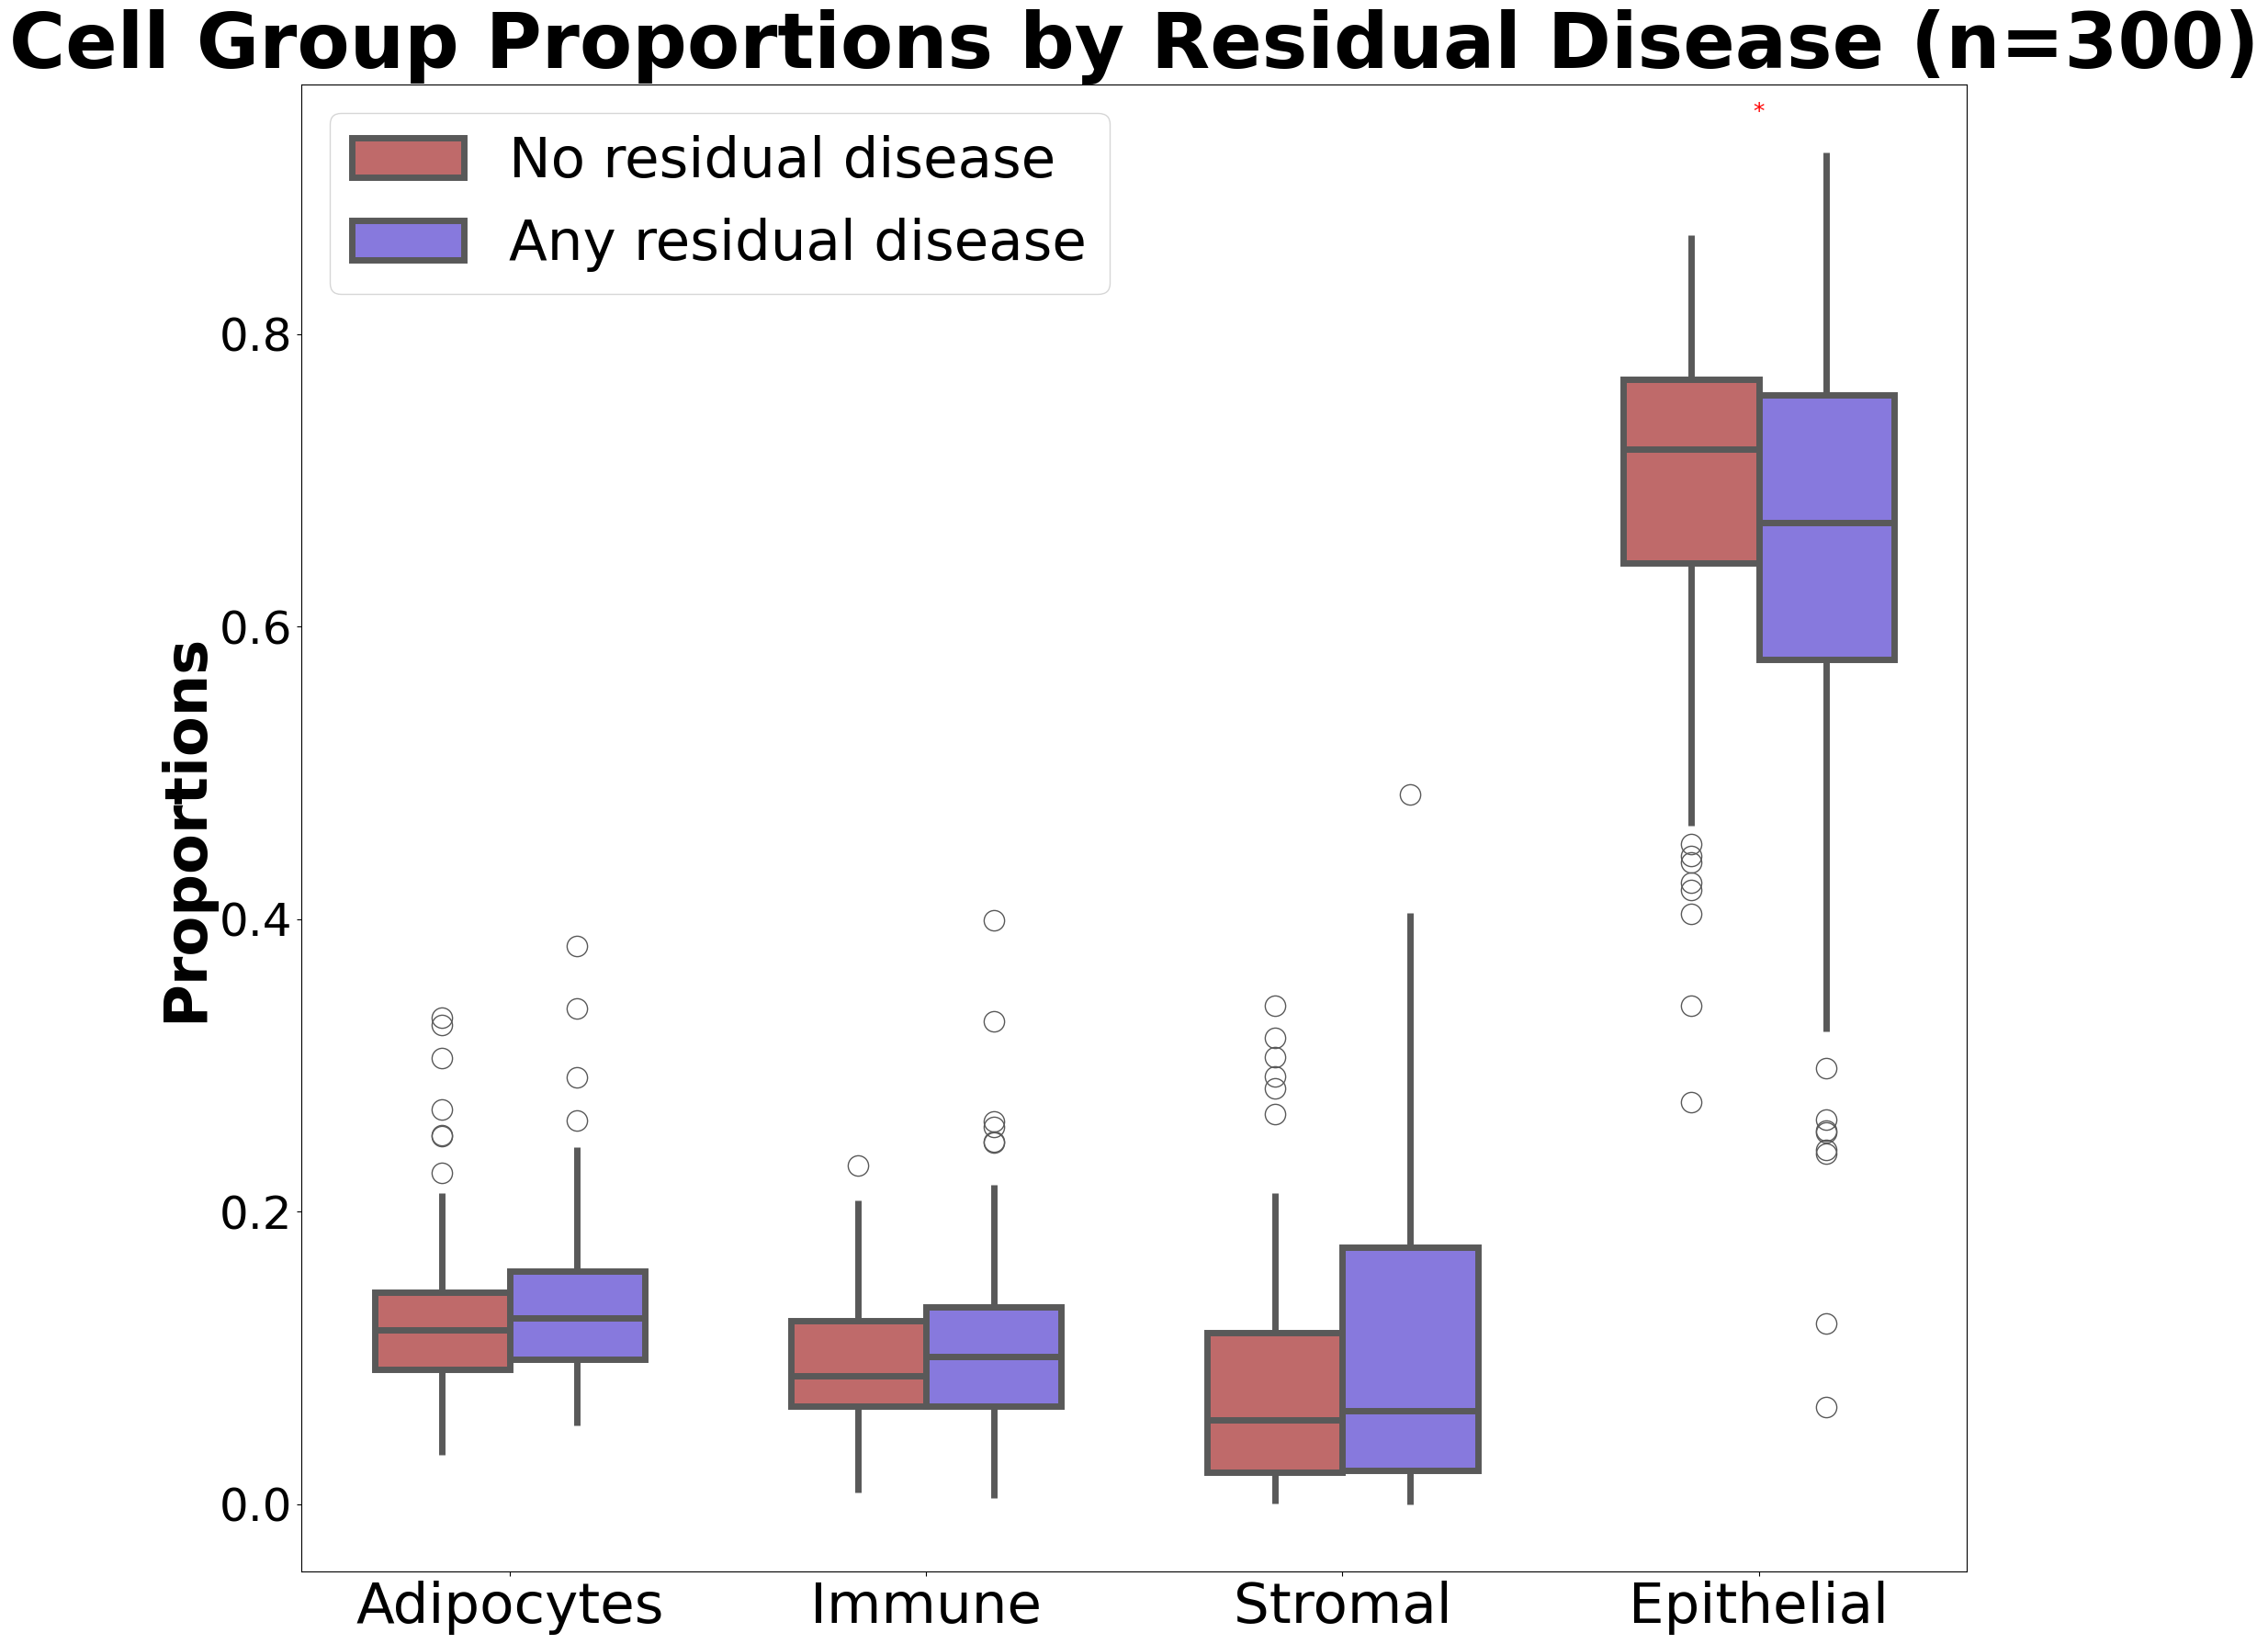

In [14]:
# ------------------------------------------------------------------
# 3.  Box-plot with significance stars
# ------------------------------------------------------------------
long_all = df[["AnyResidual"] + fractions].melt(
    id_vars="AnyResidual", var_name="Fraction", value_name="Prop"
)
# turn 0/1 into readable strings
long_all["ResidualClass"] = long_all["AnyResidual"].map(
    {0: "No residual", 1: "Any residual"}
)

palette = {"No residual": "steelblue", "Any residual": "orange"}
palette = {0: "indianred", 1: "mediumslateblue"}  # 0 = No residual, 1 = Any residual
# --- draw the box-plot ------------------------------------------------------
plt.figure(figsize=(20, 18))
ax = sns.boxplot(
    data=long_all,
    x="Fraction",
    y="Prop",
    hue="AnyResidual",
    palette=palette,
    width=0.65,
    showcaps=False,
    fliersize=16,
    linewidth=5,
)

# --- manual legend: grab one box per class ---------------------------------
handles, labels = ax.get_legend_handles_labels()  # original
# Each box-plot cluster produces two artists (median & box); pick the 1st & 2nd
new_handles = [handles[0], handles[1]]
new_labels = ["No Residual Tumor", "Any Residual Tumor"]

ax.legend(new_handles, new_labels, frameon=False, title="", loc="best")

# --- add significance stars -------------------------------------------------
for i, frac in enumerate(fractions):
    star = hp.p_to_star(out.loc[out.Fraction == frac, "p_bonf"].values[0])
    if star:
        ymax = long_all.loc[long_all.Fraction == frac, "Prop"].max()
        ax.text(
            i, ymax + 0.02, star, ha="center", va="bottom", color="red", fontsize=18
        )

plt.title(
    f"Cell Group Proportions by Residual Disease (n={df.shape[0]})",
    fontsize=60,
    fontweight="bold",
)
plt.legend(
    [handles[0], handles[1]],
    ["No residual disease", "Any residual disease"],
    title="",
    fontsize=44,
    loc="best",
)
plt.ylabel("Proportions", fontsize=46, fontweight="bold")
plt.xlabel("", fontsize=46, fontweight="bold")
plt.xticks(fontsize=44)
plt.yticks(fontsize=36)
plt.tight_layout()
plt.show()